In [1]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")

In [2]:
# ==============================
# 2. Load Dataset
# ==============================
ds = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = ds["train"].to_pandas()
val_df   = ds["validation"].to_pandas()
test_df  = ds["test"].to_pandas()

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Repo card metadata block was not found. Setting CardData to empty.


Train: (1724, 5) Val: (370, 5) Test: (370, 5)


In [3]:
# ==============================
# 3. Build Pipeline
# ==============================
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_features=20000
    )),
    ("clf", LogisticRegression(
        solver="saga",
        max_iter=5000,
        multi_class="multinomial"
    ))
])


In [4]:
# ==============================
# 4. Hyperparameter Tuning
# ==============================
param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__penalty": ["l2"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(train_df["transcription"].fillna(""), train_df["medical_specialty"])

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Params: {'clf__C': 10, 'clf__penalty': 'l2'}



--- Validation Report ---
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.89      0.95      0.92       107
      ENT - Otolaryngology       1.00      0.62      0.76        13
          Gastroenterology       0.89      0.83      0.86        29
     Hematology - Oncology       0.81      0.68      0.74        19
                Nephrology       0.91      0.62      0.74        16
                 Neurology       0.61      0.56      0.59        48
              Neurosurgery       0.27      0.31      0.29        13
   Obstetrics / Gynecology       0.92      0.96      0.94        24
             Ophthalmology       1.00      0.90      0.95        10
                Orthopedic       0.72      0.81      0.76        62
     Pediatrics - Neonatal       0.62      1.00      0.77        10
   Psychiatry / Psychology       0.80      0.80      0.80        10
                 Radiology       0.20      0.11      0.14         9

                  a

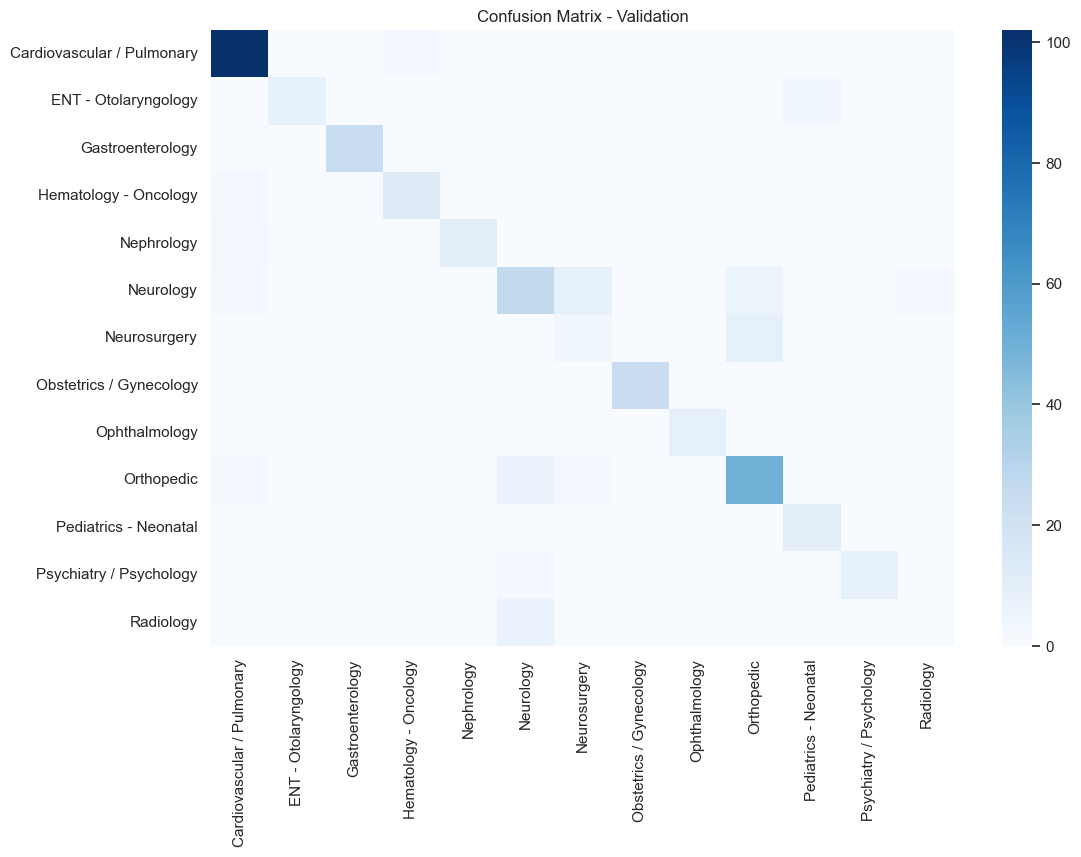


--- Test Report ---
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.92      0.96      0.94       109
      ENT - Otolaryngology       1.00      0.64      0.78        14
          Gastroenterology       0.92      0.83      0.87        41
     Hematology - Oncology       0.50      0.60      0.55        15
                Nephrology       1.00      0.60      0.75        10
                 Neurology       0.63      0.66      0.65        47
              Neurosurgery       0.42      0.40      0.41        20
   Obstetrics / Gynecology       0.92      0.75      0.83        32
             Ophthalmology       0.80      0.73      0.76        11
                Orthopedic       0.72      0.75      0.74        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0.67      0.71         9
                 Radiology       0.00      0.00      0.00         2

                  accurac

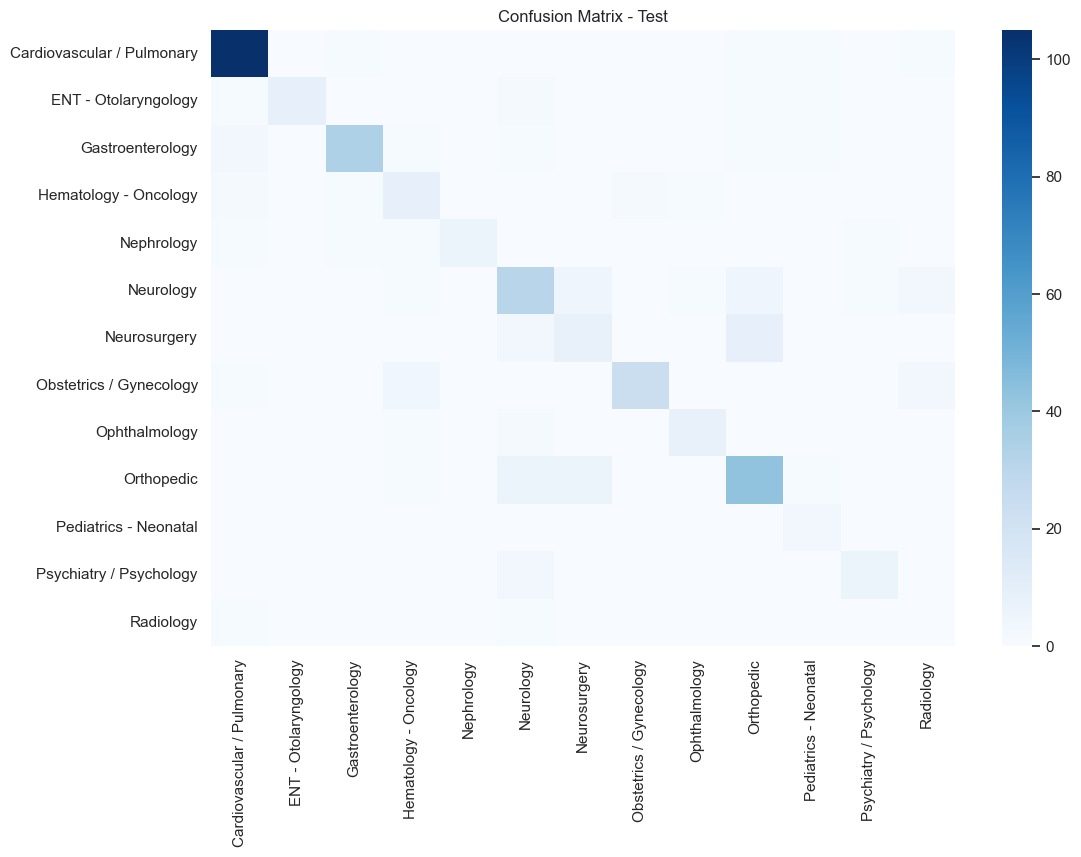

In [5]:
# ==============================
# 5. Evaluation on Validation & Test
# ==============================
def evaluate(model, df, name="Validation"):
    X, y_true = df["transcription"].fillna(""), df["medical_specialty"]
    y_pred = model.predict(X)
    print(f"\n--- {name} Report ---")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, cmap="Blues",
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xticks(rotation=90)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

evaluate(best_model, val_df, "Validation")
evaluate(best_model, test_df, "Test")


In [6]:
# ==============================
# 6. Save Final Model
# ==============================
import os
os.makedirs("../artifacts", exist_ok=True)
joblib.dump(best_model, "../artifacts/model.joblib")
print("Model saved to ../artifacts/model.joblib")


Model saved to ../artifacts/model.joblib
